# Spatial Regression

Standard regression models, whether ordinary least squares (univariate) or multiple linear regression, do not consider *where* observations or measurements were located. However, when using sptial data, the location of observations may lead to (geographical) structure in model residuals that undermine or bias the results. Spatial Regression models incorporate spatial weights to account for spatial relationships in observations with the aim of improving understanding and predictions. 

This notebook introduces spatial regression using [PySAL](https://pysal.org/) with data for the [UK Referendum on Leaving the EU](https://en.wikipedia.org/wiki/2016_United_Kingdom_European_Union_membership_referendum?wprov=srpw1_1). **Note:** this notebook requires PySAL version 2.1.0 (you may need to updgrade PySAL in your *sds2020* environment). 

# Theory of Spatial Regression

Recall that OLS univariate and multiple linear regression make assumptions about the residuals (error) in fit models: *residuals should be independent of one another with no pattern or structure*. This means both non-spatial structure (e.g. heteroscedascity) but also spatial pattern (e.g. spatial autocorrelation). 

Thus, when using regression with data collected at different locations in space we need to consider whether our residuals exhibit spatial pattern or dependence. There several ways to check this including:

- measuring global spatial autocorrelation of the residuals using e.g. Moran's I
- using tests like the Lagrange Multiplier test (see [Anselin 1998](https://doi.org/10.1111/j.1538-4632.1988.tb00159.x))

## Accounting for Spatial Dependence

**Why might spatial pattern or dependence exist?**

First, there may be a (diffusion) process that causes values observed at one location to influence values observed nearby. This is known as spatial lag.

Second, data collection associated with spatial units produce measurement error, for example when the boundaries used to collect data do not appropriately reflect the spatial nature of the underlying process. This is known as spatial error. 

Given these two general drivers, if we believe there is spatial dependence in our data there are two corresponding  ways in which we can account for it in our OLS univariate or multiple linear regression models.

1. *spatial lag model*: to account for when dependent variable $y$ in place $i$ is affected by the value of dependent (and independent variables) in both place $i$ and $j$
2. *spatial error model*: to account for when residuals are correlated between spatial locations

### Spatial Lag Model

The spatial lag model is useful when we believe values of our dependent variable $y$ in place $i$ is affected by the value of dependent (and independent variables) in both place $i$ and $j$. This situation is illustrated by the figure below, in which arrows indicate influence.

![illustration of the spatial lag model](img/SpatialLagModel_Anselin.png "Illustration of the Spatial Lag Model")

The **spatial lag model** introduces a spatial weights matrix $w$ into the model as a predictor:

$$
y_i = \beta_0 + \beta_1x_i + \rho w_iy_i + \epsilon_i 
$$

where $\rho$ ('rho') is a spatial autocorrelation term and $w_iy_i$ is the spatial lag of $y$ and $\epsilon_i$ ('epsilon') remains as (non-spatial) error not accounted for in the rest of the model. 

### Spatial Error Model

The spatial error model is useful when residuals are correlated between spatial locations and we think this is not due to spatial interactions in our dependent variable, but due to other, unexplained variables (not included in the model). This situation is illustrated by the figure below, in which arrows indicate influence.

![illustration of the spatial error model](img/SpatialErrorModel_Anselin.png "Illustration of the Spatial Error Model")

In contrast the **spatial error model** introduces a spatial weights matrix into the model as a function of the error in the model:

$$
y_i = \beta_0 + \beta_1x_i + \lambda w_i.\xi_i + \epsilon_i
$$

where $\lambda$ ('lambda') is a measure of the spatial autocorrelation of the residuals for neighbouring residuals and $\xi_i$ ('xi') is the spatial component of the error term ($\epsilon_i$ is the non-spatial error).

## Spatial Lag or Spatial Error?

We'll see how to apply each of the spatial regression models below using python. But first... **how do we decide which approach to take?**

Ward and Gleditsch (2008, p.59) provide thoughtful advice:

> ... whether the spatially lagged $y$ model or the spatial error model is most appropriate is really a prior theoretical question, which must be considered relative to the goals of a specific research question. *If we expect to see, or are interested in, feedback, then the spatially lagged $y$ model would seem a more appropriate model.* 
>
>... the spatial error model is probably less interesting for applications in the social sciences, and in our view, *the spatial error model is appropriate primarily when researchers believe that there is some spatial pattern that will be reflected in the error term, but they are either unwilling or unable to make assumptions about the origin of the error.* The reason for this [being unable to make assumptions] is that most models proposed in the social sciences do not do a great job of specifying attributes of the individual observations that fully capture the observed spatial clustering. As a result, there is still a lot of leverage [utility] in undertaking that specification in the context of a spatially lagged dependent variable. If, however, we had an area in which most of the important mechanisms were understood and fully specified in the systematic component of the model, and if there were still some correlation in the error terms, it would be useful to employ a spatial error model to correct for this residual nuisance. [emphasis added, pdf available [here](https://dces.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_W7_WardGleditsch.pdf)]

Our decision-making process might therefore be best summarised as follows:

1. if we think we there is some processes or reason that is causing values of the dependent variable to depend on their neighbours' values, then we should use a spatial lag model. 

2. if we think that the dependent variable values really are *not* spatially dependent and that instead there is some other process or variable that we have not accounted for in our data that could be creating spatial dependence (in model residuals), then we should use a spatial error model. 

3. if we're really not sure which spatial model we should use, then we could take a model selection approach, fitting both models and comparing them:

    - which has lowest AIC? (is the difference > 2?)
    - which has best $r^2$ or adjusted $r^2$?
    - are $\rho$ or $\lambda$ statistically significant?

**In summary**, look for a theoretical basis to inform your choice of model and if there is a clear reason to use one model over another then use that most appropriate model. Otherwise, if it is not not so clear theoretically, you can compare model performance parameters (i.e. do model selection) to decide - but also reflect on *why* one model might be performing better than the other. 

Finally, some (e.g. Harris 2016) have suggested that you could incorporate *two* spatial weigths matrices to combine the types of model (but that gets really tricky and we won't consider that here). 

# Application of Spatial Regression (Brexit)

To see how we can use PYSAL to fit spatial regression models and to think about what they tell us, we'll continue to use the Brexit vote vs age and qualifications example as we saw in the Multiple Linear Regression notebook. 

## Setup 

The spatial models we use here require a later version of PySAL than is in the *SDS2020* environment. 

Please <span style="color:red">update the PySAL package from your *SDS2020* environment</span> through terminal:

- `conda activate sds2020`
- `conda install pysal=2.1.0`

In [1]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

# Analysis
import geopandas as gpd
import pandas as pd
#from pysal.lib import weights
#from pysal.explore import esda
#from pysal.model import spreg
import numpy as np

import pysal

import statsmodels.formula.api as smf
import statsmodels.api as sm

You may get a warning about `pandana` and `urbanaccess` but we can ignore that in this notebook. 

Check you have version `2.1.0` of pysal:

In [2]:
print(pysal.__version__)

2.0.0


Load data:

In [3]:
england_data_path = 'data/brexit/england_age_qual_vote.csv'
england = pd.read_csv(england_data_path, index_col='Area_Code')
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 326 non-null    object 
 1   Count_Persons_age        326 non-null    object 
 2   Pct_0-4                  326 non-null    float64
 3   Pct_5-7                  326 non-null    float64
 4   Pct_8-9                  326 non-null    float64
 5   Pct_10-14                326 non-null    float64
 6   Pct_15                   326 non-null    float64
 7   Pct_16-17                326 non-null    float64
 8   Pct_18-19                326 non-null    float64
 9   Pct_20-24                326 non-null    float64
 10  Pct_25-29                326 non-null    float64
 11  Pct_30-44                326 non-null    float64
 12  Pct_45-59                326 non-null    float64
 13  Pct_60-64                326 non-null    float64
 14  Pct_65-74        

In [4]:
lads = gpd.read_file("data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


In [6]:
Egdf = lads.merge(england, how='inner', 
                  left_index=True, right_index=True)

Egdf.to_file("EnglandBrexit.gjson", driver="GeoJSON")

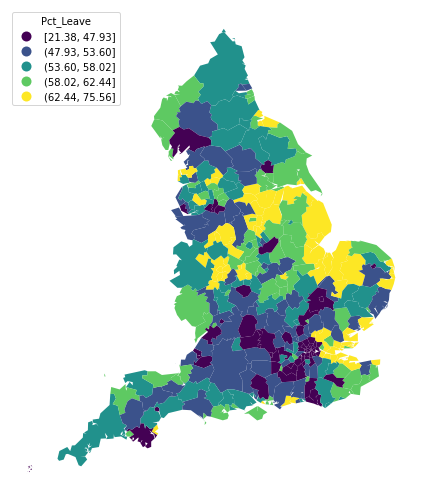

In [6]:
col='Pct_Leave' 
fig, ax = plt.subplots(1, figsize=(9, 9))
Egdf.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

Create a variable for the % of people over 65 years old. 

In [7]:
old = Egdf[['Pct_65-74','Pct_75-84','Pct_85-89','Pct_90p']]
Egdf['Pct_65p'] = old.sum(axis=1)

Let's remove the City of London as we found previously that this point has high leverage in our data

In [8]:
Egdf = Egdf.drop('E09000001',axis=0)

And now remind ourselves of what we found using non-spatial MLR:

In [9]:
l4_p65_mod = smf.ols("Pct_Leave ~ Pct_Level4 + Pct_65p", data=Egdf)
l4_p65_mod_fit = l4_p65_mod.fit()
print(l4_p65_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Pct_Leave   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     716.6
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          2.66e-119
Time:                        09:15:11   Log-Likelihood:                -929.95
No. Observations:                 325   AIC:                             1866.
Df Residuals:                     322   BIC:                             1877.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.2813      1.551     48.543      0.0

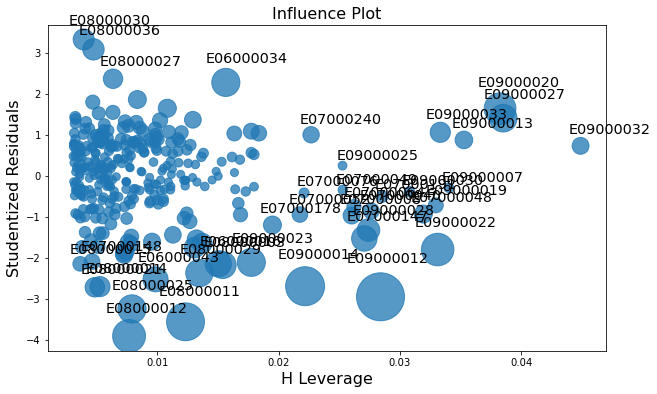

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(l4_p65_mod_fit, alpha=0.05, 
                                 criterion="cooks", ax=ax)

## Spatial Autocorrelation

In a previous notebook using the Brexit data for the whole of Great Britain (England, Scotland and Wales). Here we are using data only for England. So let's check what spatial autocorrelation exists in our dependent variable (% leave vote) for *this* dataset: 

In [11]:
wKNN8 = pysal.lib.weights.KNN.from_dataframe(Egdf, k=8)
wKNN8.transform = 'r'

In [12]:
moran = pysal.explore.esda.moran.Moran(Egdf['Pct_Leave'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.575
0.001


This is still strong, positive and statistically significant global autocorrelation. 

Just as a non-normally distributed dependent variable often means non-normally distributed   residuals in regression, so spatial dependence in the dependent variable often means spatial dependence in the residuals. Let's check this, by calculating Moran's I for our non-spatial regression model above:

In [13]:
l4_p65_moran = pysal.explore.esda.moran.Moran(l4_p65_mod_fit.resid_pearson, 
                                              wKNN8)

print(round(l4_p65_moran.I,3))
print(round(l4_p65_moran.p_sim,3))

0.329
0.001


The spatial autocorrelation isn't as strong in the residuals, but it is still quite strong and statistically significant. We should definitely consider accounting for spatial dependence in our regression models of these data.

## Regression with PySAL

PySAL provides functionality for both non-spatial and spatial regression via [the `spreg` module](https://pysal.org/spreg/).

### Non-Spatial

For example, to repeat our non-spatial model using PySAL, we can use the `OLS` function:

In [14]:
variable_names = ['Pct_Level4', 'Pct_65p']

m1 = pysal.model.spreg.OLS(
    Egdf[['Pct_Leave']].values, 
               Egdf[variable_names].values,
               name_y='Pct_Leave',
               name_x=variable_names)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   Pct_Leave                Number of Observations:         325
Mean dependent var  :     54.5931                Number of Variables   :           3
S.D. dependent var  :      9.8939                Degrees of Freedom    :         322
R-squared           :      0.8166
Adjusted R-squared  :      0.8154
Sum squared residual:    5818.144                F-statistic           :    716.6417
Sigma-square        :      18.069                Prob(F-statistic)     :   2.66e-119
S.E. of regression  :       4.251                Log likelihood        :    -929.953
Sigma-square ML     :      17.902                Akaike info criterion :    1865.906
S.E of regression ML:      4.2311                Schwarz criterion     :    1877.258

-----------------------------------------------------------------------------

Check you can see where results in this output from `spreg.OLS` correspond to output from `smf.ols` For example:

- where is $r^2$? 
- where is the correlation coefficient for each independent variable? 
- where is AIC?

From the `spreg.OLS` object (`m1`) we can access:

- predicted y-values using `.predy`
- residuals using `.u`

For example, we can use these to plot residuals against predicted y-values

Text(0, 0.5, 'Residuals (z)')

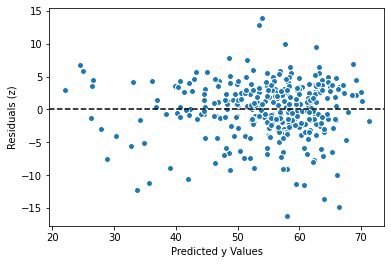

In [15]:
#m1.u is actual residuals, not standardised 
plt.plot(m1.predy, 
         m1.u, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Residuals (z)') 

And we can check Moran's I for the residuals as above:

In [16]:
m1_moran = pysal.explore.esda.moran.Moran(m1.u, wKNN8)
print(round(m1_moran.I,3))
print(round(m1_moran.p_sim,3))

0.329
0.001


### Spatial Lag

To fit a spatial lag model we can use `.spreg.ML_Lag` in a similar way to fitting a non-spatial model with PySAL:

In [17]:
variable_names = ['Pct_Level4', 'Pct_65p']

m2 = pysal.model.spreg.ML_Lag(Egdf[['Pct_Leave']].values,
                  Egdf[variable_names].values,
                  w=wKNN8,
                  name_y='Pct_Leave',
                  name_x=variable_names)
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   Pct_Leave                Number of Observations:         325
Mean dependent var  :     54.5931                Number of Variables   :           4
S.D. dependent var  :      9.8939                Degrees of Freedom    :         321
Pseudo R-squared    :      0.8300
Spatial Pseudo R-squared:  0.8059
Sigma-square ML     :      16.591                Log likelihood        :    -918.345
S.E of regression   :       4.073                Akaike info criterion :    1844.690
                                                 Schwarz criterion     :    1859.825

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/home/james/anaconda3/envs/john-snow/lib/python3.9/site-packages/scipy/optimize/_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Check you understand the output. In particular, note the `W_Pct_Leave` variable - this is the spatial lag parameter estimate $\rho$ (rho), measuring the average influence on observations by their neighboring observations. With $p < 0.001$ we can see that it is significant, i.e. the spatial dependence it represents is statistically significant.

Compare this model to our non-spatial model:

- is the $r^2$ better or worse?
- how does it compare according to AIC?

Our model has improved and $\rho$ is statistically significant, so does that mean all spatial dependence has been removed from the error in the model?

In [18]:
m2_moran = pysal.explore.esda.moran.Moran(m2.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

0.245
0.001


Apparently not. The strength of spatial autocorrelation in model residuals is reduced, but it is still statistically significant. 

### Spatial Error Model

Let's try a Spatial Error Model. We can do that using the `spreg.ML_Error` function: 

In [19]:
m3 = pysal.model.spreg.ML_Error(Egdf[['Pct_Leave']].values,
                  Egdf[variable_names].values,
                  w=wKNN8,
                  name_y='Pct_Leave',
                  name_x=variable_names)
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   Pct_Leave                Number of Observations:         325
Mean dependent var  :     54.5931                Number of Variables   :           3
S.D. dependent var  :      9.8939                Degrees of Freedom    :         322
Pseudo R-squared    :      0.8124
Sigma-square ML     :      12.082                Log likelihood        :    -879.513
S.E of regression   :       3.476                Akaike info criterion :    1765.027
                                                 Schwarz criterion     :    1776.378

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

As before, check you understand the output. Note in this output we now see the lambda variable - this is the spatial error parameter estimate $\lambda$, representing correlation in spatial component of model error. As above, with $p < 0.001$ we can see that it is significant, i.e. the spatial dependence it represents is statistically significant.

Compare this model to our non-spatial and spatial lag models:

- is the $r^2$ better or worse?
- how does it compare according to AIC?

The $r^2$ is very similar to the non-spatial model (worse than the spatial lag model) but the AIC is much better than both the previous models. 

The regression coefficients for our predictors are now quite different in this model, qualification is now -1.06 vs -0.95 previously and p65 is now 0.66 vs 0.37 previously. 

Again, $\lambda$ is statistically significant, so does that mean all spatial dependence has been removed from the error in the model?

In [20]:
m3_moran = pysal.explore.esda.moran.Moran(m3.u, wKNN8)
print(round(m3_moran.I,3))
print(round(m3_moran.p_sim,3))

0.361
0.001


No, in fact the spatial dependence in the residuals is even *stronger* than in the non-spatial model! So what do we do here... 

## Interpreting Results

Well, first we can acknowledge that even if there is spatial dependence in model residuals, in all three models the predictor variables we have been using (age and qualifications) have been statistically significant, and the $r^2$ is consistently ~0.8 (i.e. very high). This suggests these variables really *are* important. 

Second, we should think about what may be driving the spatial autocorrelation in our data: is it that there is strong autocorrelation (and therefore neighbour relations are very important) for % leave vote, age, qualifications or all variables? 

My hunch is that yes, there is strong autocorrelation in all three variables (less so for age) and that this is driven by the 'cold spot' locations in southern England (London and around Oxfordshire) and the the 'hot spots' further north (in East England and across into Wales). This is likely a situation that we should consider including some kind of [categorical](https://stackoverflow.com/questions/55738056/using-categorical-variables-in-statsmodels-ols-class) 'regional' variable (e.g. [UK NUTS level 2](https://en.wikipedia.org/wiki/NUTS_statistical_regions_of_the_United_Kingdom) regions) to capture variation at a more coarse spatial level. This may improve model performance and reduce spatial dependence in model errors. 

And of course there are many other factors that might have influenced voting behaviour that we could include in our models (including [poverty](https://blogs.lse.ac.uk/brexit/2016/08/31/brexit-should-be-a-wake-up-call-in-the-fight-against-inequality/), [origin of birth](https://doi.org/10.1177/0308518X16665844) and more). 

But model performance (in terms of $r^2$) is already really good so really it would just be interesting to see if a regional variable or other predictors could help explain the vote. 

With the models have here, I would probably choose the Spatial Lag model based on higher $r^2$ and weaker spatial autocorrelation in residuals. And because I think spatial dependence is important here and not something to ignore (but really I'd also like to confirm that spatial correlation in all the variables really is important). And then I'd go on to discuss the implications of the model:

- age and qualifications are *really* important to understand the Brexit leave vote (both statistically significant at 99.9% confidence)
- the variables % 65+ and % with University qualifications explain ~83% of the variation in % leave vote
- each 0.94% increase in population with a University qualification reduced Brexit leave vote by 1%
- each 0.37 increase in population aged 65 or older increased Brexit leave vote by 1%

# Further Resources

Anselin and Rey (2014) *Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace and PySAL.*

Gaidus (2016) [Modeling San Francisco Crime Rates - A Spatial Econometric Approach](http://andrewgaidus.com/Spatial_Econonometric_Modeling/)

Goodwin and Heath (2016) The 2016 Referendum, Brexit and the Left Behind: An Aggregate‐level Analysis of the Result *Political Quarterly* 87(3) 323-332 [doi: 10.1111/1467-923X.12285](https://doi.org/10.1111/1467-923X.12285)

Chapter 10 in Harris (2016) *Quantitative Geography* London: SAGE

[*Spatial Regression*](https://geographicdata.science/book/notebooks/11_regression.html) in Rey *et al.* (2020) *Geographic Data Science with Python*

Ward and Gleditsch (2018) *Spatial Regression Models* London: SAGE [[2008 edition pdf available  here](https://dces.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_W7_WardGleditsch.pdf)] And see online resources [here](http://www.srmbook.com/)

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).